In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.distributions.empirical_distribution import ECDF
from datetime import datetime as dt


warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# Test Dataset
test_df = pd.read_csv("./data/test.csv", parse_dates=True, low_memory=False, index_col='Date')

# Sample Submission
sample_df = pd.read_csv("./data/sample_submission.csv")

In [4]:
def preprocessing():
    # Load Train Dataset
    train_df = pd.read_csv("./data/train.csv", parse_dates=True, low_memory=False, index_col='Date')
    # Load Store Data
    store_df = pd.read_csv("./data/store.csv", low_memory=False)
    
    # Add date features
    train_df['Year'] = train_df.index.year
    train_df['Month'] = train_df.index.month
    train_df['Day'] = train_df.index.day
    train_df['DayName'] = train_df.index.day_name()
    train_df['WkofYr'] = train_df.index.weekofyear
    train_df['DayofYr'] = train_df.index.day_of_year
    train_df['DayofWk'] = train_df.index.day_of_week
    # Calculate Sales Per Customer
    train_df['SalesPerCustomer'] = train_df.Sales/train_df.Customers
    # Closed stores and days which didn't have any sales are not included in forecasts
    train_df = train_df[(train_df["Open"] != 0) & (train_df['Sales'] != 0)]

    # fill NaN with a median value (skewed distribuion)
    store_df['CompetitionDistance'].fillna(store_df['CompetitionDistance'].median(), inplace = True)
    # replace NA's by 0
    store_df.fillna(0, inplace = True)

    # merge the above
    merged_df = pd.merge(train_df, store_df, how = 'inner', on = 'Store')
    return merged_df

In [5]:
train_store_df = preprocessing()
train_store_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,DayName,WkofYr,DayofYr,DayofWk,SalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,31,Friday,31,212,4,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,30,Thursday,31,211,3,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,29,Wednesday,31,210,2,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,28,Tuesday,31,209,1,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,27,Monday,31,208,0,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [14]:
def train_preprocessing():
    # Load Train Dataset
    train_df = pd.read_csv("./data/train.csv", parse_dates=True, low_memory=False, index_col='Date')
    
    # Add date features
    train_df['Year'] = train_df.index.year
    train_df['Month'] = train_df.index.month
    train_df['Day'] = train_df.index.day
    train_df['DayName'] = train_df.index.day_name()
    train_df['WkofYr'] = train_df.index.weekofyear
    train_df['DayofYr'] = train_df.index.day_of_year
    train_df['DayofWk'] = train_df.index.day_of_week
    # Calculate Sales Per Customer
    train_df['SalesPerCustomer'] = train_df.Sales/train_df.Customers
    # Closed stores and days which didn't have any sales are not included in forecasts
    train_df = train_df[(train_df["Open"] != 0) & (train_df['Sales'] != 0)]
    return train_df

In [15]:
train_df =train_preprocessing()
train_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,DayName,WkofYr,DayofYr,DayofWk,SalesPerCustomer
Date,,,,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,Friday,31,212,4,9.482883
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,Friday,31,212,4,9.702400
2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,Friday,31,212,4,10.126675
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,Friday,31,212,4,9.342457
2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,Friday,31,212,4,8.626118


### Time Series Analysis
---
##### Seasonality

In [16]:
# convert input data into float type
train_df['Sales'] = train_df['Sales']*1.0

# Store types
sales_a = train_df[train_df.Store == 2]["Sales"]
sales_b = train_df[train_df.Store == 85]["Sales"].sort_index(ascending=True) # solve the reverse order
sales_c = train_df[train_df.Store == 1]["Sales"]
sales_d = train_df[train_df.Store == 13]["Sales"]

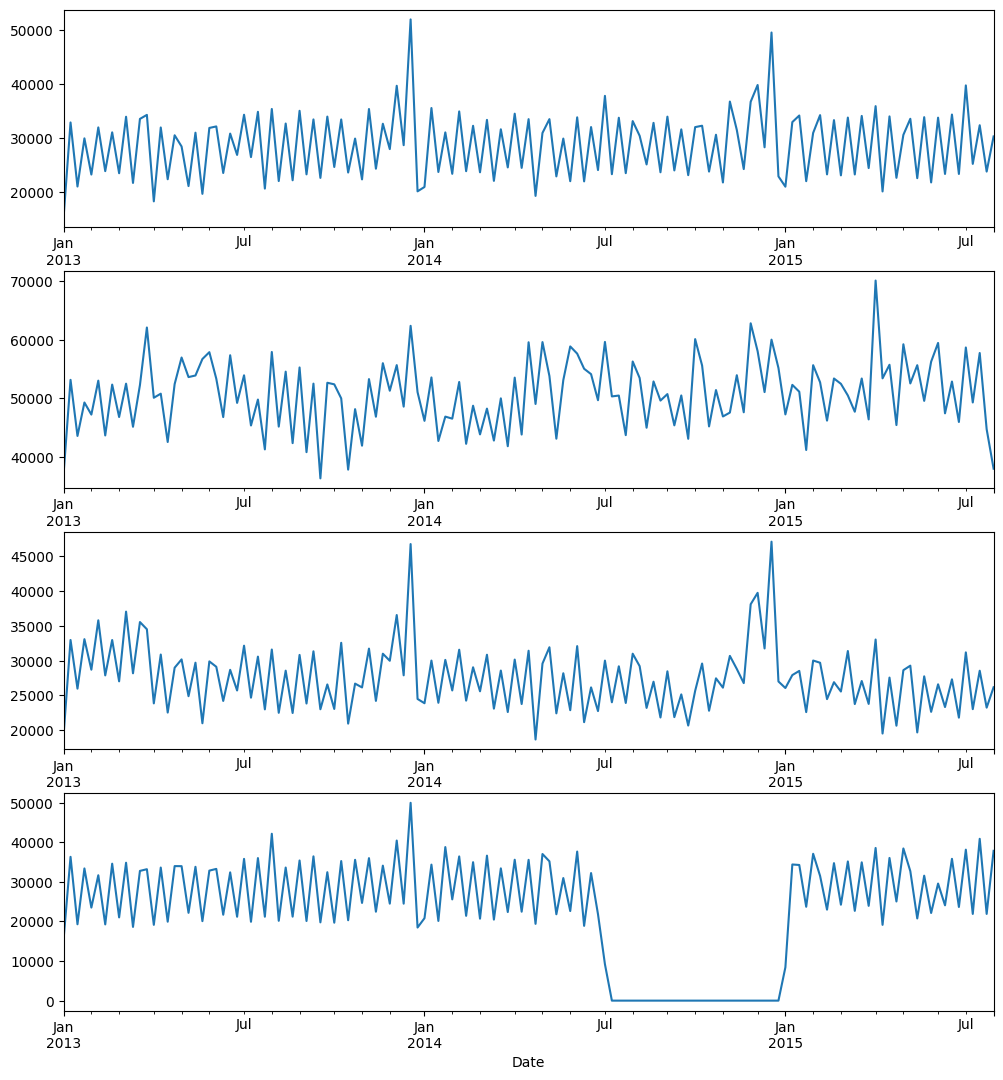

In [18]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(12,13))

# store types
sales_a.resample('W').sum().plot(ax = ax1)
sales_b.resample('W').sum().plot(ax = ax2)
sales_c.resample('W').sum().plot(ax = ax3)
sales_d.resample('W').sum().plot(ax = ax4)
plt.show()

##### Yearly Trend

ValueError: x must have 2 complete cycles requires 730 observations. x only has 621 observation(s)

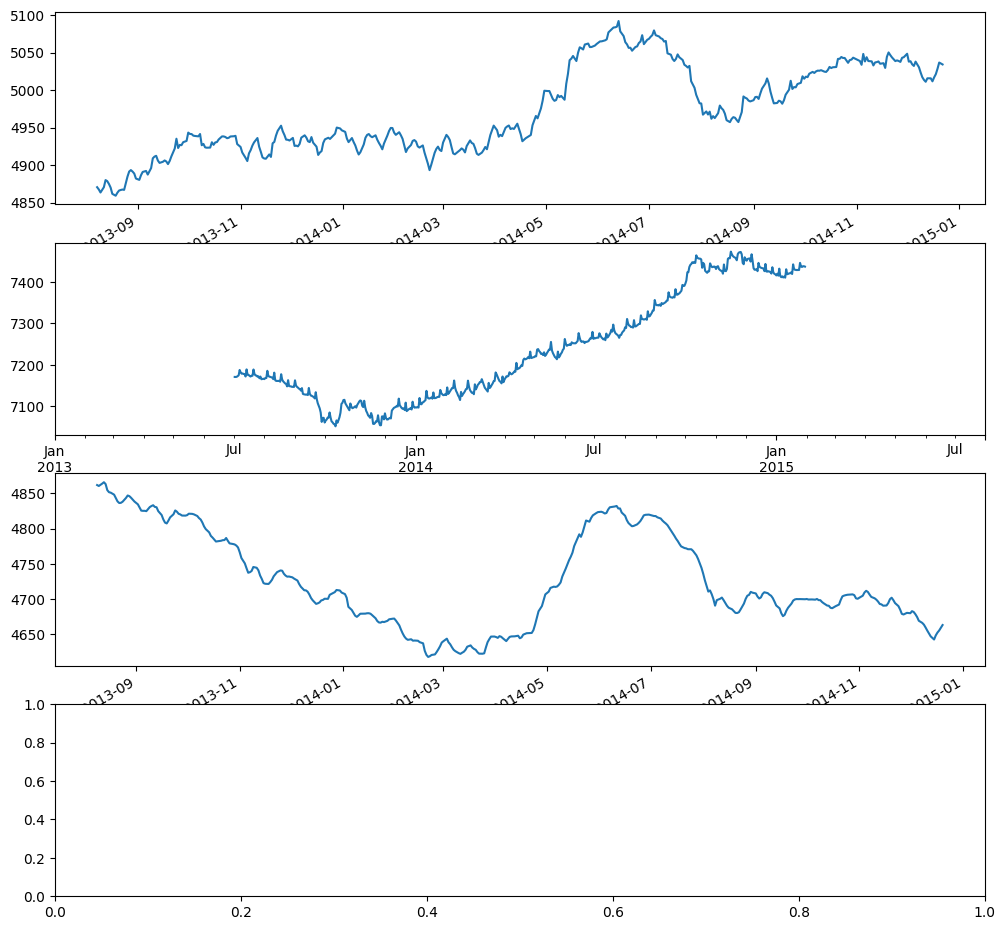

In [21]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# monthly
decomposition_a = seasonal_decompose(sales_a, model = 'additive', period = 365)
decomposition_a.trend.plot(ax = ax1)

decomposition_b = seasonal_decompose(sales_b, model = 'additive', period = 365)
decomposition_b.trend.plot(ax = ax2)

decomposition_c = seasonal_decompose(sales_c, model = 'additive', period = 365)
decomposition_c.trend.plot(ax = ax3)

decomposition_d = seasonal_decompose(sales_d, model = 'additive', period = 365)
decomposition_d.trend.plot(ax = ax4)

plt.show()

##### Autocorrelation
---

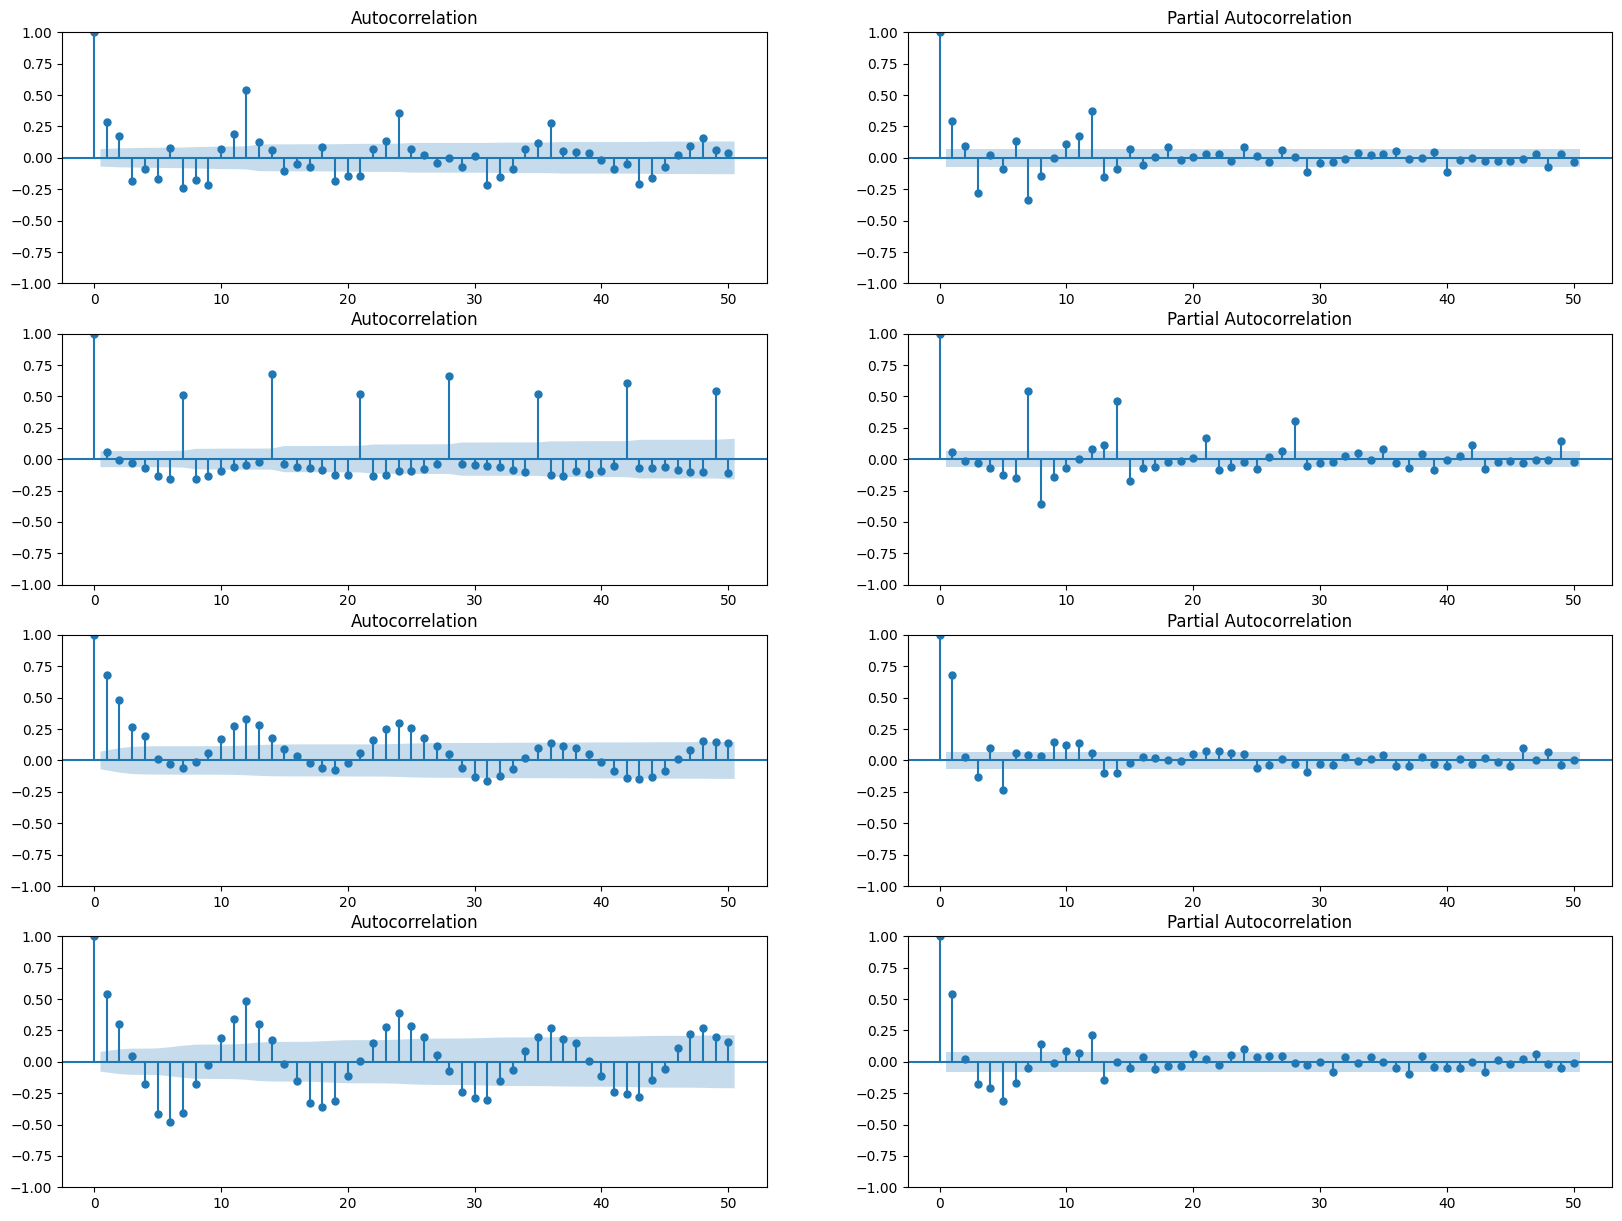

In [26]:
# figure for subplots
plt.figure(figsize = (20, 15))

# acf and pacf for A
plt.subplot(421); plot_acf(sales_a, lags = 50, ax = plt.gca())
plt.subplot(422); plot_pacf(sales_a, lags = 50, ax = plt.gca())

# acf and pacf for B
plt.subplot(423); plot_acf(sales_b, lags = 50, ax = plt.gca())
plt.subplot(424); plot_pacf(sales_b, lags = 50, ax = plt.gca())

# acf and pacf for C
plt.subplot(425); plot_acf(sales_c, lags = 50, ax = plt.gca())
plt.subplot(426); plot_pacf(sales_c, lags = 50, ax = plt.gca())

# acf and pacf for D
plt.subplot(427); plot_acf(sales_d, lags = 50, ax = plt.gca())
plt.subplot(428); plot_pacf(sales_d, lags = 50, ax = plt.gca())

plt.show()